# Juggling RL project

## Install dependencies

The required libraries are:
- numpy
- matplotlib
- mujoco
- mediapy
- gymnasium
- tensorflow
- os
- visualkeras

These libraries can be installed using pip or conda depending on your environment. 

On windows :

It is also necessary to have ffmpeg software installed, in particular its bin folder in your path : <br>

On Windows : tuto - https://www.wikihow.com/Install-FFmpeg-on-Windows <br>
download - https://www.gyan.dev/ffmpeg/builds/


## Import Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media
import gymnasium as gym
import tensorflow as tf
from tensorflow.keras import layers
import visualkeras

## The gym environment

We created our environment in envs/Juggling_Env.py.

In [2]:
import custom_gym

env = gym.make('Juggler',render_mode="rgb_array")

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))


upper_bound = env.action_space.high
lower_bound = env.action_space.low

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  6
Size of Action Space ->  3
Max Value of Action ->  [ 2.8973  1.7628 -0.0698]
Min Value of Action ->  [-2.8973 -1.7628 -3.0718]


## DDPG

To implement better exploration by the Actor network, we use noisy perturbations

We experimented with Ornstein-Uhlenbeck_process noise and Gaussian noise.

The gaussian noice seemed to provide a better result

In [3]:

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)


In [4]:
class GaussActionNoise:
    def __init__(self, means, std_deviations):
        self.means = means
        self.std_devs = std_deviations

    def __call__(self):
        return np.random.normal(self.means,self.std_devs,size=3)

The `Buffer` class implements Experience Replay.

**Critic loss** - Mean Squared Error of `y - Q(s, a)`
where `y` is the expected return as seen by the Target network,
and `Q(s, a)` is action value predicted by the Critic network. `y` is a moving target
that the critic model tries to achieve; we make this target
stable by updating the Target model slowly.
**Actor loss** - This is computed using the mean of the value given by the Critic network
for the actions taken by the Actor network. We seek to maximize this quantity.
Hence we update the Actor network so that it produces actions that get
the maximum predicted value as seen by the Critic, for a given state.

In [5]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    @tf.function
    def update(
        self,
        state_batch,
        action_batch,
        reward_batch,
        next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)

In [6]:
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))


Here we define the Actor and Critic networks. These are basic Dense models
with `ReLU` activation.

In [7]:
def get_actor():

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dropout(0.2)(out)
    out = layers.Dense(512,activation="relu")(out)
    out = layers.Dense(640, activation="relu")(out)
    #out = layers.BatchNormalization()(out)
    outputs = layers.Dense(num_actions, activation="sigmoid")(out)

    
    #outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    #state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)
    #action_out = layers.BatchNormalization()(action_out)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    #out = layers.BatchNormalization()(out)
    out = layers.Dense(256, activation="relu")(out)
    out = layers.Dense(512, activation="relu")(out)
    out = layers.Dense(640, activation="relu")(out)
    #out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1,activation="relu")(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model


In [8]:
def normalize_action(action):
    return (action+upper_bound)/(2*upper_bound)
def denormalize_action(action):
    return (action*2*upper_bound)-upper_bound

def normalize_action2(action):
    return (action+1)/2
def denormalize_action2(action):
    return (action-0.5)*2


`policy()` returns an action sampled from our Actor network plus some noise for
exploration.

In [9]:
def policy(state, noise_object,expert):
    if expert:
        expert_command = [3, [[0, -0.476, -2.14], [0.9, -0.38, -2.05], [1, -0.3, -1.95],
                [1.1, -0.2, -1.85], [1.2, -0.1, -1.78], [1.3, 0, -1.74], [1.5, 0.1, -1.68],
                [1.7, 0.15, -1.6], [2.4, 0.2, -1.18], [2.8, -0.476, -2.14]]]
       
        #print("Expert Command : "+str(expert_command[1][int(((env.data.time*10)//0.2)%10)]))
        val=abs(expert_command[1][0][0]-env.data.time)
        command=0
        for i in range(10):
            if(abs(expert_command[1][i][0]-env.data.time)<val):
                val=abs(expert_command[1][i][0]-env.data.time)
                command=i
            
        return [[0.,expert_command[1][command][1],expert_command[1][command][2]]]
        
    else:
        sampled_actions = tf.squeeze(actor_model(state))
        noise = noise_object()

        # Adding noise to action
        sampled_actions = denormalize_action2(sampled_actions.numpy()) + noise

        # We make sure action is within bounds
        legal_action = np.clip(sampled_actions, lower_bound, upper_bound)
        
        return [np.squeeze(legal_action)]

## Training hyperparameters

In [10]:
std_dev = 0.2

#means = np.mean([[0, -0.476, -2.14], [0.9, -0.38, -2.05], [1, -0.3, -1.95],
#                [1.1, -0.2, -1.85], [1.2, -0.1, -1.78], [1.3, 0, -1.74], [1.5, 0.1, -1.68],
#                [1.7, 0.15, -1.6], [2.4, 0.2, -1.18], [2.8, -0.476, -2.14]],0)
#means[0]=0
#print(means)
means=[0,-0.42,-1.98]
ga_noise = GaussActionNoise(means,[0,0.5,0.5])
ou_noise = OUActionNoise(mean=means, std_deviation=np.array([0.1,0.1,0.1]))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.0002
actor_lr = 0.0001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 201
# Discount factor for future rewards
gamma = 0.1
# Used to update target networks
tau = 0.005

buffer = Buffer(50000000, 64)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-24 16:30:53.540618: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-24 16:30:53.540725: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Models Summary

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense (Dense)               (None, 256)               1792      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dense_2 (Dense)             (None, 640)               328320    
                                                                 
 dense_3 (Dense)             (None, 3)                 1923      
                                                                 
Total params: 463,619
Trainable params: 463,619
Non-trainable

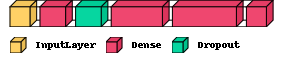

In [11]:
actor_model.summary()
visualkeras.layered_view(actor_model, legend=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 16)           112         ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 32)           544         ['dense_4[0][0]']                
                                                                                            

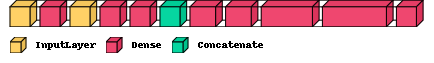

In [12]:
critic_model.summary()
visualkeras.layered_view(critic_model, legend=True)

## Training loop

In [13]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

#? For debug
render_all=False

for ep in range(total_episodes):

    prev_state = env.reset()[0]
    episodic_reward = 0
    frames = []
    n=0

    while True:
        
        if(ep%100==0 or render_all):
            frame=env.render()
            frames.append(frame)
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ga_noise,False)
        
        # Recieve state and reward from environment.
        state, reward, terminated,truncated, info = env.step(action[0])
        
        if(n==0):
            reward=0
        
        buffer.record((prev_state,normalize_action2(action[0]), reward, state))
        episodic_reward += reward
        n+=1
        buffer.learn()
        update_target(target_actor.variables, actor_model.variables,tau)# 1. if ep==0 else tau)
        update_target(target_critic.variables, critic_model.variables, tau)#1. if ep==0 else tau)

        # End this episode when `done` is True
        if terminated or truncated:
            #print(info)
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)
    if(ep%100==0 or render_all):
        media.show_video(frames)
    
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Ep Reward is ==> {}".format(ep, episodic_reward))
    avg_reward_list.append(avg_reward)

2023-02-24 16:30:54.699507: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-24 16:30:54.699674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 16:30:55.152024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 16:30:55.241776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Episode * 0 * Ep Reward is ==> 0
Episode * 1 * Ep Reward is ==> 0
Episode * 2 * Ep Reward is ==> 0
Episode * 3 * Ep Reward is ==> 0
Episode * 4 * Ep Reward is ==> 0
Episode * 5 * Ep Reward is ==> 0
Episode * 6 * Ep Reward is ==> 0
Episode * 7 * Ep Reward is ==> 0
Episode * 8 * Ep Reward is ==> 0
Episode * 9 * Ep Reward is ==> 0
Episode * 10 * Ep Reward is ==> 1
Episode * 11 * Ep Reward is ==> 1
Episode * 12 * Ep Reward is ==> 0
Episode * 13 * Ep Reward is ==> 0
Episode * 14 * Ep Reward is ==> 0
Episode * 15 * Ep Reward is ==> 0
Episode * 16 * Ep Reward is ==> 1
Episode * 17 * Ep Reward is ==> 0
Episode * 18 * Ep Reward is ==> 0
Episode * 19 * Ep Reward is ==> 0
Episode * 20 * Ep Reward is ==> 0
Episode * 21 * Ep Reward is ==> 0
Episode * 22 * Ep Reward is ==> 0
Episode * 23 * Ep Reward is ==> 1
Episode * 24 * Ep Reward is ==> 0
Episode * 25 * Ep Reward is ==> 0
Episode * 26 * Ep Reward is ==> 0
Episode * 27 * Ep Reward is ==> 0
Episode * 28 * Ep Reward is ==> 1
Episode * 29 * Ep Reward

Episode * 100 * Ep Reward is ==> 0
Episode * 101 * Ep Reward is ==> 0
Episode * 102 * Ep Reward is ==> 0
Episode * 103 * Ep Reward is ==> 0
Episode * 104 * Ep Reward is ==> 0
Episode * 105 * Ep Reward is ==> 1
Episode * 106 * Ep Reward is ==> 0
Episode * 107 * Ep Reward is ==> 0
Episode * 108 * Ep Reward is ==> 0
Episode * 109 * Ep Reward is ==> 0
Episode * 110 * Ep Reward is ==> 0
Episode * 111 * Ep Reward is ==> 1
Episode * 112 * Ep Reward is ==> 0
Episode * 113 * Ep Reward is ==> 0
Episode * 114 * Ep Reward is ==> 0
Episode * 115 * Ep Reward is ==> 1
Episode * 116 * Ep Reward is ==> 2
Episode * 117 * Ep Reward is ==> 0
Episode * 118 * Ep Reward is ==> 0
Episode * 119 * Ep Reward is ==> 0
Episode * 120 * Ep Reward is ==> 0
Episode * 121 * Ep Reward is ==> 0
Episode * 122 * Ep Reward is ==> 0
Episode * 123 * Ep Reward is ==> 0
Episode * 124 * Ep Reward is ==> 0
Episode * 125 * Ep Reward is ==> 0
Episode * 126 * Ep Reward is ==> 0
Episode * 127 * Ep Reward is ==> 0
Episode * 128 * Ep R

Episode * 200 * Ep Reward is ==> 0


### Plot

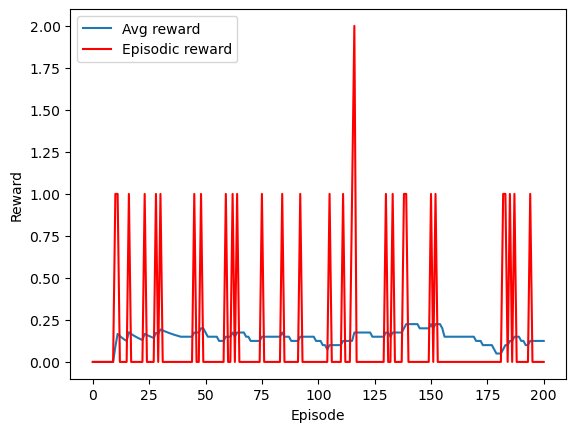

In [14]:
plt.plot(avg_reward_list,label="Avg reward")
plt.plot(ep_reward_list,"r",label="Episodic reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend(loc="upper left")
plt.show()

### Save

In [15]:
actor_model.save_weights("actor.h5")
critic_model.save_weights("critic.h5")

target_actor.save_weights("target_actor.h5")
target_critic.save_weights("target_critic.h5")